<img src="images/keolalai.jpg" alt="banner" width="100%">


# Power Patterns: Harnessing Electricity for Innovation
* Author: [Redacted]
* Expected Run Time: 30s
* Minimum Hadware Requirements: 8 core CPU, 16 GB of RAM
* Submission Summary: By extracting size, temporal, and uncertainty features, we segment buildings into distinct clusters and develop targeted demand response programs. The proposed DR programs aim to improve grid stability and efficiency by incorporating measures like aggregation, seasonal adjustments, time-of-use pricing, and battery storage.

In [ ]:
%%html

<style>
  .table-of-contents {
    background-color: #f8f9fa;
    border: 1px solid #dee2e6;
    padding: 1.5rem;
    margin-bottom: 2rem;
    border-radius: 0.25rem;
  }

  .table-of-contents ul {
    padding-left: 0;
    margin-bottom: 0;
  }

  .table-of-contents li {
    margin-bottom: 0.5rem;
  }

  .table-of-contents a {
    color: #007bff;
    text-decoration: none;
  }

  .table-of-contents a:hover {
    text-decoration: underline;
  }
</style>

<div class='table-of-contents' id='toc'>
  <h2>Table of Contents</h2>
  <ul>
    <li><a href='#eda'>Exploratory Data Analysis</a></li>
    <li><a href='#feature-engineering'>Feature Engineering</a></li>
      <ul>
        <li><a href='#size-features'>Total Yearly Energy Consumption</a></li>        
        <li><a href='#temporal-features'>Temporal Features</a></li>
          <ul>
            <li><a href='#seasonality'>Seasonality</a></li>        
            <li><a href='#weekday-weekend'>Weekday Weekend Consumption Ratio</a></li>        
          </ul>    
        <li><a href='#uncertainty-features'>Uncertainty Features</a></li>        
        <ul>
            <li><a href='#spectral-flatness'>Spectral Flatness</a></li>
            <li><a href='#predictability'>Predictability</a></li>
        </ul>
      </ul>
    <li><a href='#unsupervised-learning'>Unsupervised Learning</a></li>
      <ul>
        <li><a href='#size-clusters'>Size-Based Clusters</a></li>        
        <li><a href='#temporal-clusters'>Temporal-Based Clusters</a></li>        
        <li><a href='#uncertainty-clusters'>Uncertainty-Based Clusters</a></li>        
      </ul>    
    <li><a href='#interpretation'>Interpretation</a></li>
      <ul>
        <li><a href='#size-program'>Small Building Aggregation</a></li>        
        <li><a href='#seasonal-program'>Seasonal Demand Response</a></li>        
        <li><a href='#weekday-weekend-program'>Weekday Peak Reduction</a></li>        
        <li><a href='#uncertainty-program'>Reducing Grid Uncertainty with Battery Storage</a></li>        
      </ul>        
    <li><a href='#conclusion'>Conclusion</a></li>
    <li><a href='#references'>References</a></li>
  </ul>
</div>

In [ ]:
# <button id=toggleAllButton>Toggle All Code Cells</button><script>function toggleAllCodeCells(){document.querySelectorAll(".code_cell .input").forEach(function(e){e.style.display=codeCellsHidden?"":"none"}),codeCellsHidden=!codeCellsHidden}var codeCellsHidden=!1;function toggleCodeCells(e){var l=document.querySelectorAll(".code_cell .input")[e];l.style.display="none"===l.style.display?"":"none"}toggleAllCodeCells(),document.getElementById("toggleAllButton").addEventListener("click",toggleAllCodeCells)</script>

In [3]:
import os
import contextlib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')  

DATA_PATH = '../data'
TARGET_COL = 'out.electricity.total.energy_consumption'
WEEKDAY_NAMES = np.array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
MONTH_NAMES = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

<a id="eda"></a>
# Exploratory Data Analysis<a href="#toc"><i class="fa fa-home"></i></a>

In this analysis, we will begin by highlighting two buildings which we've selected which exhibit the prototypical patterns that we'd like to analyze. By examining these buildings in detail, we aim to gain valuable insights into the characteristics and patterns present in the data. These insights will guide us in the process of feature engineering, where we will extract meaningful and informative features from the raw data. First, we'll visualize the raw time series data. 

In [4]:
building_data = [
    pd.read_parquet(f'{DATA_PATH}/data/{building_num}.parquet')
    for building_num in range(1, 1278)
]

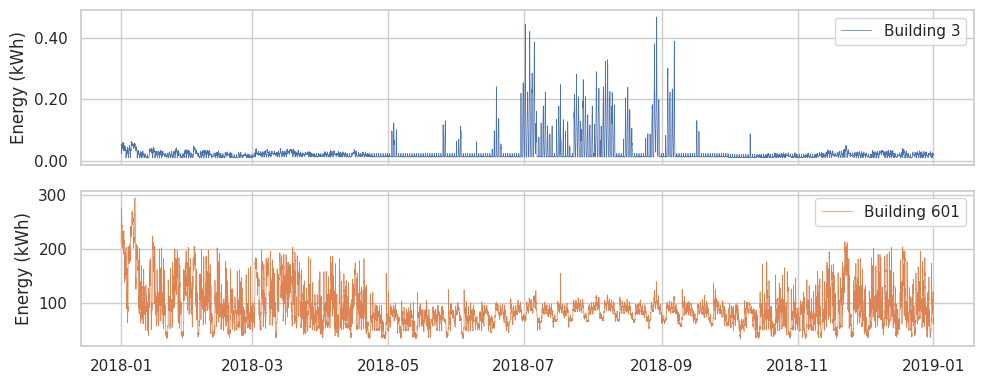

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
for i, building_num in enumerate([3, 601]):
    df = building_data[building_num - 1]
    sns.lineplot(x='timestamp', y=TARGET_COL, data=df, ax=axes[i],
                 label=f'Building {building_num}', color=f'C{i}', linewidth=0.5)
    axes[i].set_ylabel('Energy (kWh)')
    axes[i].yaxis.set_major_formatter('{x:.2f}' if i == 0 else '{x:0.0f}')
    axes[i].legend(loc='upper right')
plt.xlabel('')
plt.tight_layout()
plt.show()

This figure reveals several key patterns in energy consumption. First, usage varies significantly throughout the year, indicating strong seasonal fluctuations. Notably, building 3 peaks in summer, while building 601 peaks in winter. Additionally, building 601 consistently consumes two to three orders of magnitude more energy than building 3, highlighting the influence of building size and usage patterns.

Although the raw series contains all the information, it is hard to make sense of in this form. The most important time features are month, day of the week, and time of the day [[1]](#ref1). To visualize how the short-term seasonality patterns (those that depend on day of the week and time of the day) change from month to month, we'll calculate the average weekly energy consumption in each month. 

Building 3


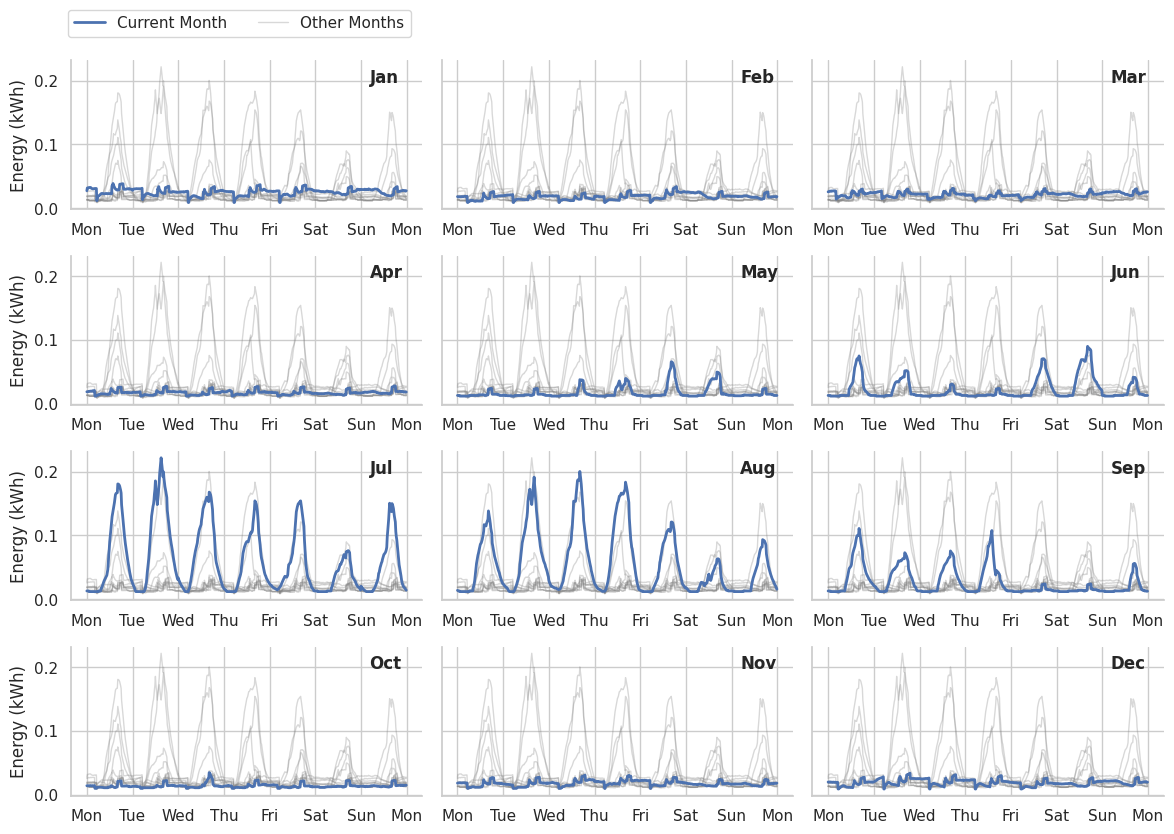



Building 601


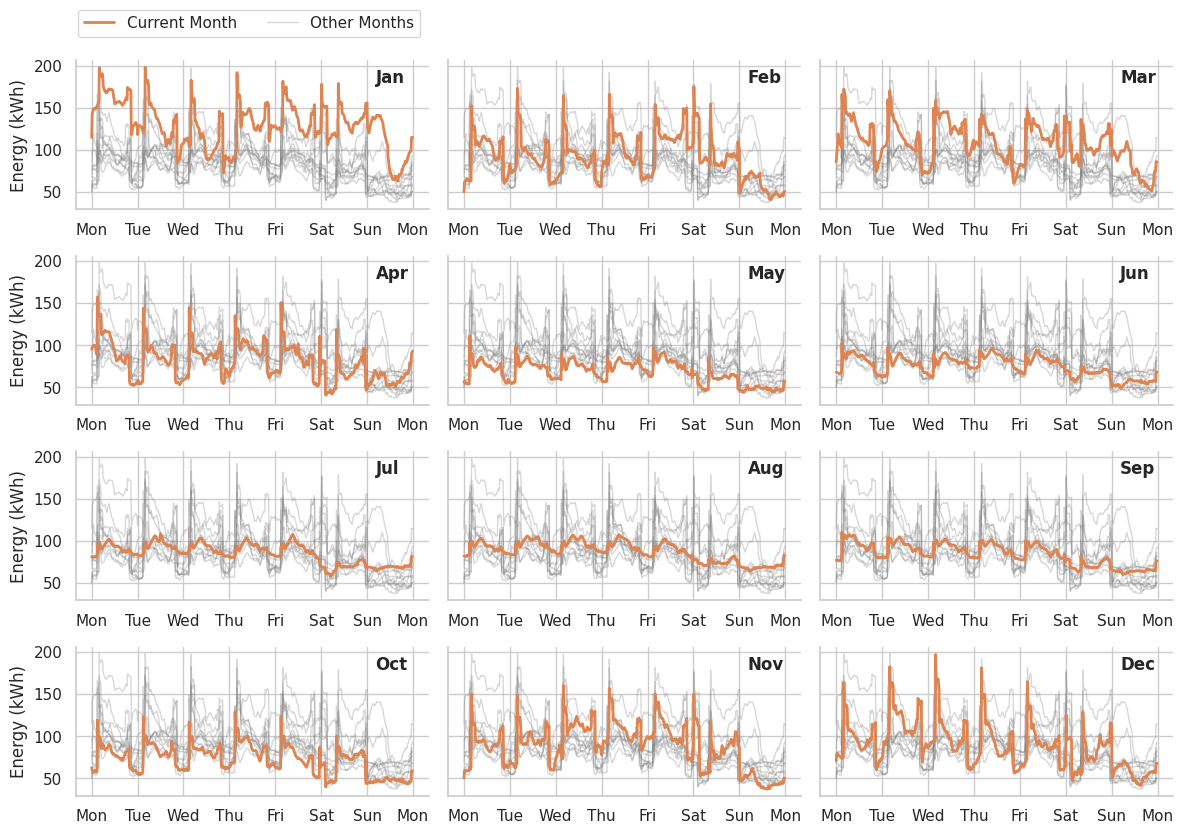

In [6]:
def plot_building_energy(building_num, color='k'):
    
    df = building_data[building_num - 1]
    dt = df.timestamp.dt
    df['time_of_week'] = (dt.dayofweek * 96) + (dt.hour * 4) + (dt.minute // 15)
    df['month_name'] = dt.month_name().str.slice(0,3)
    df['month'] = dt.month

    tmp = df.groupby(['month_name', 'month', 'time_of_week'])[TARGET_COL].mean()\
        .reset_index().sort_values('month', ignore_index=True)
    
    g = sns.relplot(
        data=tmp,
        x='time_of_week', y=TARGET_COL, col='month_name', color=color,
        kind='line', linewidth=2, zorder=5, label='Current Month',
        col_wrap=3, height=2, aspect=2.0, legend=False,
    )
    
    for i, (month, ax) in enumerate(g.axes_dict.items()):
        ax.text(0.85, 0.85, month, transform=ax.transAxes, fontweight='bold')
        sns.lineplot(
            data=tmp, x='time_of_week', y=TARGET_COL, units='month_name', 
            label='Other Months' if i == 0 else None,
            estimator=None, alpha=0.3, color='0.5', linewidth=1, ax=ax, legend=False,
        )

        ax.xaxis.set_tick_params(which='both', labelbottom=True)
        ax.set_xticks(96*np.arange(8), [WEEKDAY_NAMES[i % 7][:3] for i in np.arange(8)])
    
    handles, labels = g.axes_dict[list(g.axes_dict.keys())[0]].get_legend_handles_labels()
    g.fig.legend(handles[:2], labels[:2], loc='upper left', ncol=2, bbox_to_anchor=(0.065, 1.05))

    g.fig.subplots_adjust(hspace=0.1, wspace=0.1)
    g.set_axis_labels('', 'Energy (kWh)')    
    g.set_titles('')
    plt.tight_layout()
    plt.show()

    
for i,building_num in enumerate([3, 601]):
    print((2*'\n' if i == 1 else '') + f'Building {building_num}')
    x = plot_building_energy(building_num, color=f'C{i}')

In the figures above, the gray lines are the average weekly enregy consumption for the months. In each subplot the current month is highlighted. 

We now see some additional insights:
* The day-to-day energy consumption patterns vary from month to month, indicating that seasonality plays a significant role in shaping a building's energy usage.
* The winter months exhibit more noise and variability in energy consumption compared to the summer months, suggesting that predicting energy demand during colder periods may be more challenging.
* There appears to be a notable difference in weekday and weekend energy consumption patterns for building 601, with Sundays showing a particularly distinct pattern.

These insights provide a starting point for further analysis and feature extraction. By identifying the key factors that influence energy consumption, such as seasonality, weekday/weekend differences, and building-specific patterns, we can develop better clustering models. In the following sections, we will delve deeper into these insights and uncover additional patterns and relationships within the data.


<a id="feature-engineering"></a>
# Feature Engineering <a href="#toc"><i class="fa fa-home"></i></a>

Feature engineering is a crucial step in improving the performance of clustering models, which we will be using later in the analysis. By carefully selecting and crafting relevant features, we can highlight important patterns and structures within the data that can enhance the ability of the clustering algorithms to effectively group similar data points together. Throughout this process, we will leverage the knowledge gained from EDA to make informed decisions about which features to create and how to transform the data in a way that maximizes the effectiveness of the subsequent clustering task.


Here's a summary of all the features that we will be examining. 

<a id="feature-engineering-toc"></a>
| **Feature Name** | **Type** | **Description** |
| :--- | :--- | :--- |
| **<a href="#size-features">Total Yearly Energy Consumption</a>** | Size | Total energy consumption for the year. |
| **<a href="#seasonality">Seasonality</a>** | Temporal | Average energy consumption for each month, day of week, and time of day (vector of length 8064). 
 | **<a href="#weekday-weekend">Weekday Weekend Consumption Ratio</a>** | Temporal | Average weekday consumption divided by the average weekend consumption. |
| **<a href="#spectral-flatness">Spectral Flatness</a>** | Uncertainty | Logarithm of the ratio of the geometric mean to the arithmetic mean of the power spectrum of a signal. |
| **<a href="#predictability">Predictability</a>** | Uncertainty |  One minus RMSE between a baseline model's predictions (seasonal moving average). |
| **<a href="#anomaly-detection">Anomaly Detection</a>** | Uncertainty | Average consumption of observations that differ significantly from a baseline model's predictions. |
            

<a id="size-features"></a>
## Total Yearly Energy Consumption  <a href="#feature-engineering-toc"><i class="fa fa-arrow-up"></i></a>

One of the things we've noticed during EDA is that some buildings have an energy consumption that is order of magnitudes larger than the other buildsings. Let's look into this by inspecting the `total_yearly_energy_consumption` of each building.

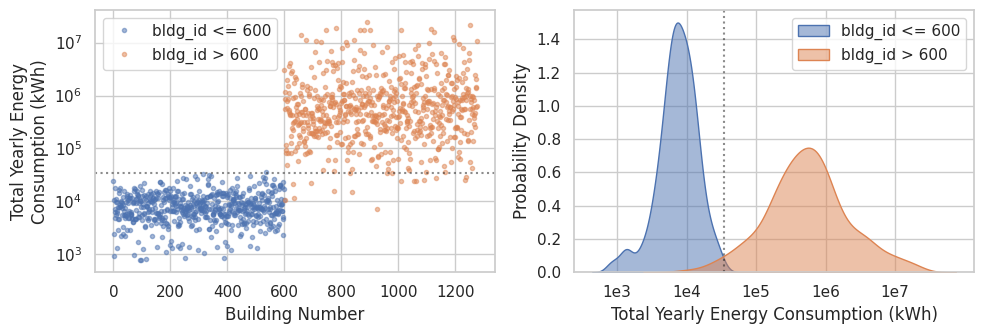

In [7]:
total_yearly_energy_consumption = np.array([df[TARGET_COL].sum() for df in building_data])


plt.figure(figsize=(10, 3.5))

plt.subplot(1, 2, 1)
plt.semilogy(range(600), total_yearly_energy_consumption[:600], '.', alpha=0.5, label='bldg_id <= 600')
plt.semilogy(range(600, 1277), total_yearly_energy_consumption[600:], '.', alpha=0.5, label='bldg_id > 600')
plt.axhline(35000, linestyle=':', color='k', alpha=0.5)
plt.xlabel('Building Number')
plt.ylabel('Total Yearly Energy\nConsumption (kWh)')
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(np.log10(total_yearly_energy_consumption[:600]), fill=True, alpha=0.5, label='bldg_id <= 600')
sns.kdeplot(np.log10(total_yearly_energy_consumption[600:]), fill=True, alpha=0.5, label='bldg_id > 600')
plt.axvline(np.log10(35000), color='k', linestyle=':', alpha=0.5)
plt.xticks(range(3, 8), [f'1e{x}' for x in range(3, 8)])
plt.xlabel('Total Yearly Energy Consumption (kWh)')
plt.ylabel('Probability Density')
plt.legend()

plt.tight_layout()
plt.show()

The subplot on the left shows the `total_yearly_energy_consumption` for all the buildings. Interestingly, buildings in the first half of the dataset have very low energy consumption compared to the buildings in of the second half. Roughly speaking, the buildings in the first half are about 1-3 orders of magnitude smaller than the buildings in the second half. Unfortunately, this building number based dichotomy is artificial and likely due to "data leakage" (not shuffling the building ids); that said, we could have derived the separation by looking at the distribution of consumption. The subplot on the right shows the distribution of `total_yearly_energy_consumption`. We can split the buildings into small and large using a single cutoff point. If choose the cutoff point to be the value at which the two densities are equal (~35000 kWh and shown as a dotted line in both subplots), we would allow us to arrive at a similar conclusion without needing to use the building number. 

As we'll see in the subsequent analysis, the smaller buildings are likely to be residential and the larger buildings are likely to be commercial. We'll refer to the buildings in the first half of the datset as "residential" buildings and the buildings in the second half as "commercial" buildings. Because the residential buildings are so much smaller, they will likely need to partner with an aggregator or a virtual power plant to get the most out of a DR program [[2]](#ref2), [[3]](#ref3).

<a id="temporal-features"></a>
## Temporal Features  <a href="#feature-engineering"><i class="fa fa-arrow-up"></i></a>

To focus on the shape of these patterns rather than the absolute energy use (which is already captured by the `total_yearly_energy_consumption` feature), we first standardized the data. This involves subtracting the mean and dividing by the standard deviation. This standardization effectively removes the influence of building size [[4]](#ref4).

<a id="seasonality"></a>
### Seasonality  <a href="#feature-engineering-toc"><i class="fa fa-arrow-up"></i></a>

During exploratory data analysis (EDA), we found that most insights could be derived without analyzing the raw time series directly. Instead, we summarize the data by calculating average energy consumption for each month, day of week, and time of day. This results in a `seasonality` vector of length 8064 (12 months × 7 days per week × 96 observations per day).

In [8]:
temporal_features = []
for df in building_data:    
    dt = df.timestamp.dt
    df['month'] = dt.month
    df['time_of_week'] = (dt.dayofweek * 96) + (dt.hour * 4) + (dt.minute // 15)
    x = df.groupby(['month', 'time_of_week'])[TARGET_COL].mean().values
    temporal_features.append((x - np.mean(x))/np.std(x))
    
temporal_features = np.array(temporal_features)
weekly_average = temporal_features.reshape((1277, -1, 7*96)).mean(1)

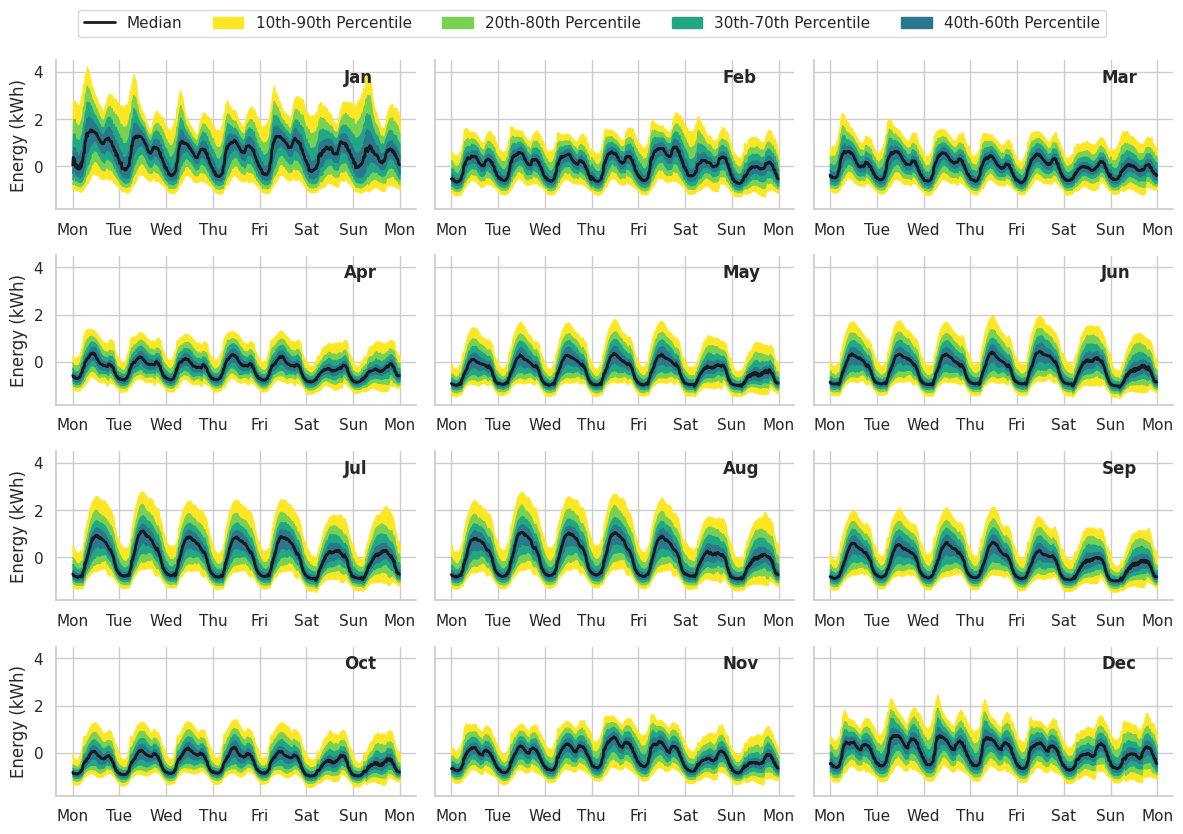

In [9]:
df = pd.DataFrame(dict(
    month_name=np.repeat([x[:3] for x in MONTH_NAMES], 7*96),
    time_of_week=np.tile(range(7*96), 12),
    value_mean=temporal_features.mean(0),
    value_10=np.quantile(temporal_features, 0.1, 0),
    value_20=np.quantile(temporal_features, 0.2, 0),
    value_30=np.quantile(temporal_features, 0.3, 0),
    value_40=np.quantile(temporal_features, 0.4, 0),
    value_50=np.quantile(temporal_features, 0.5, 0),   
    value_60=np.quantile(temporal_features, 0.6, 0),
    value_70=np.quantile(temporal_features, 0.7, 0),   
    value_80=np.quantile(temporal_features, 0.8, 0),
    value_90=np.quantile(temporal_features, 0.9, 0),   
))

g = sns.relplot(
    data=df,
    x='time_of_week', y='value_50', col='month_name', color='k', legend=False, label='Median', 
    estimator=None, kind='line', linewidth=2, zorder=5, col_wrap=3, height=2, aspect=2.0, 
)

for month, ax in g.axes_dict.items():
    tmp = df.loc[df.month_name == month]
    ax.fill_between(tmp.time_of_week, tmp.value_10, tmp.value_90, alpha=1.0, color='#fde724', label='10th-90th Percentile')
    ax.fill_between(tmp.time_of_week, tmp.value_20, tmp.value_80, alpha=1.0, color='#79d151', label='20th-80th Percentile')
    ax.fill_between(tmp.time_of_week, tmp.value_30, tmp.value_70, alpha=1.0, color='#22a784', label='30th-70th Percentile')
    ax.fill_between(tmp.time_of_week, tmp.value_40, tmp.value_60, alpha=1.0, color='#29788e', label='40th-60th Percentile')
    ax.text(.8, .85, month, transform=ax.transAxes, fontweight='bold')
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
    ax.set_xticks(96*np.arange(8), [WEEKDAY_NAMES[i % 7][:3] for i in np.arange(8)])

g.fig.subplots_adjust(hspace=0.1, wspace=0.1)     
g.set_axis_labels('', 'Energy (kWh)')   
g.set_titles('')

handles, labels = g.axes_dict[list(g.axes_dict.keys())[0]].get_legend_handles_labels()
g.fig.legend(handles, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.05))
plt.tight_layout() 
plt.show()

The figure above shows the empirical distribution of seasonality vectors for all the buildings. The black line represents the average seasonality vector, while the shaded regions depict various quantiles, providing insights into the variability of energy consumption patterns across the building dataset. 

Upon examining the figure, several key observations emerge. 
* Firstly, we notice higher overall energy consumption and increased variability during the winter months compared to other seasons. 
* Secondly, the seasonality patterns reveal distinct daily peaks in energy consumption. During the winter months, there appear to be two prominent peaks: one in the morning and another in the evening. In contrast, the summer months exhibit a single peak in energy consumption. 

It is important to note that this figure presents a high-level overview of the entire distribution of buildings, illustrating the general trends and patterns. However, individual buildings can have drastically different seasonality patterns that deviate from these overall trends. In fact, through our clustering analysis, we will demonstrate that we can uncover distinct patterns that are not clearly visible when taking a distributional approach.

<a id="weekday-weekend"></a>
### Weekday Weekend Consumption Ratio  <a href="#feature-engineering-toc"><i class="fa fa-arrow-up"></i></a>

To identify buildings with differing weekday/weekend energy consumption, we calculate the `weekday_weekend_consumption_ratio`: the average weekday consumption divided by the average weekend consumption. A ratio above 1 indicates higher weekday consumption, while a ratio below 1 indicates higher weekend consumption. For example, a ratio of 3 means weekday consumption is three times higher than weekend consumption.

This information can guide enrollment in demand response programs: those with higher weekday use could benefit from time-of-use pricing that incentivizes shifting consumption to weekends, while those with higher weekend use could participate in load shedding programs to reduce strain during grid emergencies.

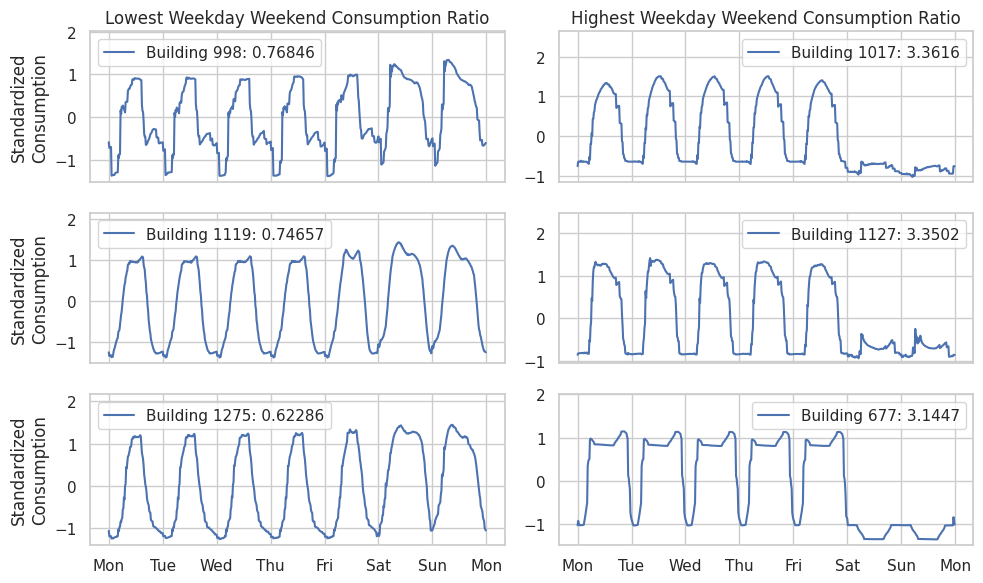

In [10]:
weekday_weekend_consumption_ratio = []
for df in building_data:
    x = df.groupby('time_of_week')[TARGET_COL].mean().values
    weekday_weekend_consumption_ratio.append(x[:96*5].mean() / x[96*5:].mean())
weekday_weekend_consumption_ratio = np.array(weekday_weekend_consumption_ratio)    


plt.figure(figsize=(10, 6))
for i, building_num in enumerate(np.argsort(weekday_weekend_consumption_ratio)[:3][::-1]):
    plt.subplot(3, 2, 2*i+1)
    plt.plot(weekly_average[building_num], label=f'Building {building_num + 1}: {weekday_weekend_consumption_ratio[building_num]:0.5g}')
    plt.ylim(None, 1.5 * weekly_average[building_num].max())
    plt.legend(loc=2)
    plt.ylabel('Standardized\nConsumption')
    if i == 0: 
        plt.title('Lowest Weekday Weekend Consumption Ratio')    
    if i == 2:
        plt.xticks(np.linspace(0, 672, 8), [WEEKDAY_NAMES[i % 7][:3] for i in np.arange(8)])
    else:
        plt.xticks(np.linspace(0, 672, 8), [])
        
for i, building_num in enumerate(np.argsort(-weekday_weekend_consumption_ratio)[:3]):
    plt.subplot(3, 2, 2*i+2)
    plt.plot(weekly_average[building_num], label=f'Building {building_num + 1}: {weekday_weekend_consumption_ratio[building_num]:0.5g}')
    plt.ylim(None, 1.75 * weekly_average[building_num].max())
    plt.legend(loc=1)
    if i == 0: 
        plt.title('Highest Weekday Weekend Consumption Ratio')    
    if i == 2:
        plt.xticks(np.linspace(0, 672, 8), [WEEKDAY_NAMES[i % 7][:3] for i in np.arange(8)])
    else:
        plt.xticks(np.linspace(0, 672, 8), [])
                
plt.tight_layout()
plt.show()    

The figure above shows weekly average energy consumption for the top 3 buildings with the lowest (left) / highest (right) `weekday_weekend_consumption_ratio`. Each subplot shows the building number as well as the corresponding `weekday_weekend_consumption_ratio` value. Buildings in the left column have a larger energy consumption on the weekdays while buildings in the right column have large energy consumption on the weekends. Surisingly, all the buildings displayed above are commercial (`bldg_id > 600`). It is interesting to look at the weekday / weekend consumption of residential and commercial buildings separately. 


<a id="uncertainty-features"></a>
## Uncertainty Features  <a href="#feature-engineering"><i class="fa fa-arrow-up"></i></a>

Uncertainty quantification plays an important role in designing a DR program. Buildings with unpredictable energy use could be enrolled in a program that provides the building with a rebate or incentive for utilizing an energy storage system. For those with predictable usage, it simplifies DR planning and improves load forecasting for efficient resource allocation. In this section, we will focus on developing features to quantify uncertainty.

<a id="spectral-flatness"></a>
### Spectral Flatness   <a href="#feature-engineering-toc"><i class="fa fa-arrow-up"></i></a>
Spectral flatness is defined as the ratio of the geometric mean to the arithmetic mean of the power spectrum of a signal. Spectral flatness measures how evenly the energy of a signal is distributed across different frequencies. A value close to 1 indicates a flat spectrum, which is characteristic of white noise (equal power at all frequencies). Conversely, a value close to 0 indicates a peaked spectrum, typical of pure tones or signals with specific frequency components. 

In energy consumption data, a high spectral flatness indicates more random or irregular usage, with less pronounced seasonal, daily, or weekly patterns. Conversely, low spectral flatness implies more predictable variations, with distinct periodic patterns, possibly driven by strong seasonality or consistent daily/weekly cycles.

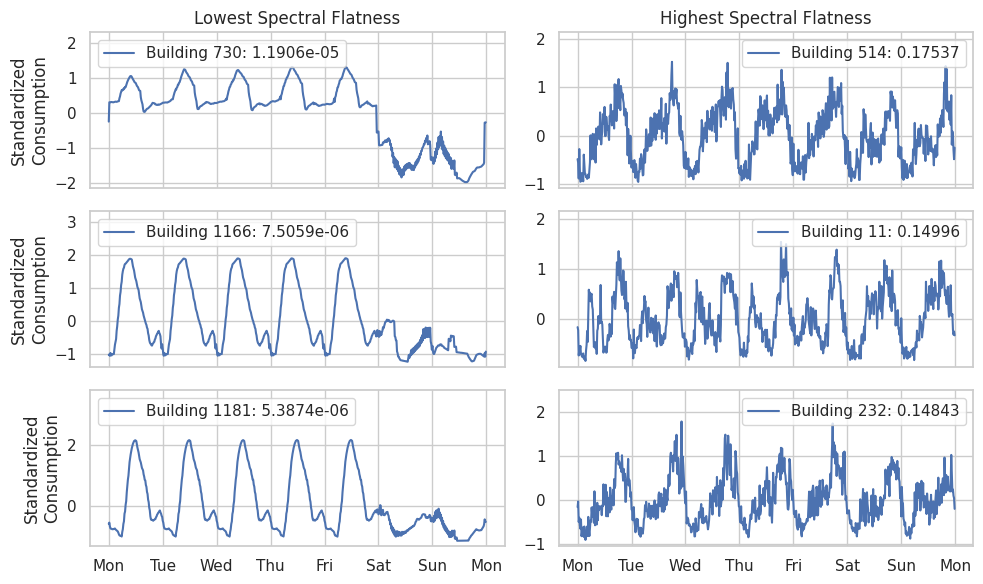

In [11]:
def calculate_spectral_flatness(signal):
    signal = signal / np.sqrt(np.mean(signal**2))
    spectrum = np.abs(np.fft.rfft(signal))**2
    geometric_mean = np.exp(np.mean(np.log(spectrum)))
    arithmetic_mean = np.mean(spectrum)
    return geometric_mean / arithmetic_mean    

spectral_flatness = np.array([calculate_spectral_flatness(df[TARGET_COL]) for df in building_data])


plt.figure(figsize=(10, 6))
for i, building_num in enumerate(np.argsort(spectral_flatness)[:3][::-1]):
    plt.subplot(3, 2, 2*i+1)
    plt.plot(weekly_average[building_num], label=f'Building {building_num + 1}: {spectral_flatness[building_num]:0.5g}')
    plt.ylim(None, 1.75 * weekly_average[building_num].max())
    plt.legend(loc=2)
    plt.ylabel('Standardized\nConsumption')
    if i == 0: 
        plt.title('Lowest Spectral Flatness')    
    if i == 2:
        plt.xticks(np.linspace(0, 672, 8), [WEEKDAY_NAMES[i % 7][:3] for i in np.arange(8)])
    else:
        plt.xticks(np.linspace(0, 672, 8), [])
        
for i, building_num in enumerate(np.argsort(-spectral_flatness)[:3]):
    plt.subplot(3, 2, 2*i+2)
    plt.plot(weekly_average[building_num], label=f'Building {building_num + 1}: {spectral_flatness[building_num]:0.5g}')
    plt.ylim(None, 1.4 * weekly_average[building_num].max())
    plt.legend(loc=1)
    if i == 0: 
        plt.title('Highest Spectral Flatness')
    if i == 2:
        plt.xticks(np.linspace(0, 672, 8), [WEEKDAY_NAMES[i % 7][:3] for i in np.arange(8)])
    else:
        plt.xticks(np.linspace(0, 672, 8), [])
                
plt.tight_layout()
plt.show()    

The figure above shows weekly average of the the top 3 buildings with the lowest (left) / highest (right) `spectral_flatness`. Each subplot shows the building number as well as the corresponding `spectral_flatness` value. Buildings in the left column have smoother energy consumption patterns while the buildings in the right column have energy consumption that is more noisy. Again, it is interesting to look at the `spectral_flatness` of residential and commercial buildings separately. 


<a id="predictability"></a>
### Predictability  <a href="#feature-engineering-toc"><i class="fa fa-arrow-up"></i></a>

In this subsection we'll a baseline model using a seasonal moving average. We'll define predictability as one minus the RMSE of the baseline model. A large value means a smaller error and a more consistent energy consumption pattern. 

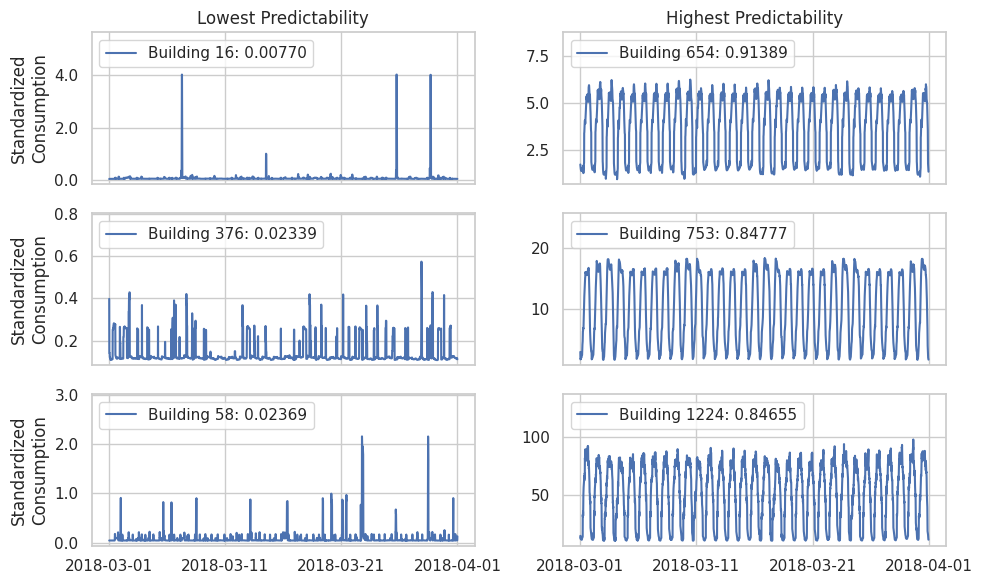

In [32]:
def smooth(signal, n=15):
    kernel = np.full(2*n+1, 1/(2*n+1))
    signal = np.apply_along_axis(np.pad, 0, signal.reshape(-1, 96), (n, n), mode='edge')
    signal = np.apply_along_axis(np.convolve, 0, signal, kernel, mode='valid').flatten()
    return signal

predictability = []
for i, df in enumerate(building_data):
    mu, sigma = df[TARGET_COL].mean(), df[TARGET_COL].std()
    df['standardized_energy'] = (df[TARGET_COL].values - mu) / sigma
    df['prediction'] = smooth(df.standardized_energy.values)
    predictability.append(np.sqrt(np.mean((df.prediction - df.standardized_energy)**2)))
predictability =  1 - np.array(predictability)


month = 3

plt.figure(figsize=(10, 6))

for i, building_num in enumerate(np.argsort(predictability)[:3]):

    df = building_data[building_num]
    df = df.loc[df.timestamp.dt.month == month]

    plt.subplot(3, 2, 2 * i + 1)
    plt.plot(df.timestamp, df[TARGET_COL],
             label=f'Building {building_num + 1}: {predictability[building_num]:0.5f}')
    plt.gca().yaxis.set_major_formatter('{x:.1f}')
    plt.xticks(pd.date_range('2018-03-01', '2018-04-01', periods=4), None if i == 2 else [])
    plt.ylim(None, 1.4 * df[TARGET_COL].max())
    plt.ylabel('Standardized\nConsumption')
    if i == 0: 
        plt.title('Lowest Predictability')
    plt.legend(loc=2)

    
for i, building_num in enumerate(np.argsort(predictability)[-3:][::-1]):

    df = building_data[building_num]
    df = df.loc[df.timestamp.dt.month == month]

    plt.subplot(3, 2, 2 * i + 2)
    plt.plot(df.timestamp, df[TARGET_COL],
             label=f'Building {building_num + 1}: {predictability[building_num]:0.5f}')
    plt.xticks(pd.date_range('2018-03-01', '2018-04-01', periods=4), None if i == 2 else [])
    plt.ylim(None, 1.4 * df[TARGET_COL].max())
    if i == 0: plt.title('Highest Predictability')
    plt.legend(loc=2)

plt.tight_layout()
plt.show()

The figure above shows actual energy consumption of the the top 3 buildings with the lowest (left) / highest (right) `predictability` in March. Each subplot shows the building number as well as the corresponding `predictability` value. Buildings in the left column have large sporadic spikes in consumption while the buildings in the right column have consumption that is very uniform. Let's look at the difference between residential and commercial buildings. 


<a id="anomaly-detection"></a>
### Anomaly Detection  <a href="#feature-engineering-toc"><i class="fa fa-arrow-up"></i></a>
We can detect the spikes in the data by looking at the absolute difference between the prediction and actual values. If the difference is larger than some threshold, we can classify that point as an anomaly. The following figure shows the results of the anomaly detection algorithm with a threshold of 2.0 for building 16 (the building with the lowest predictability).

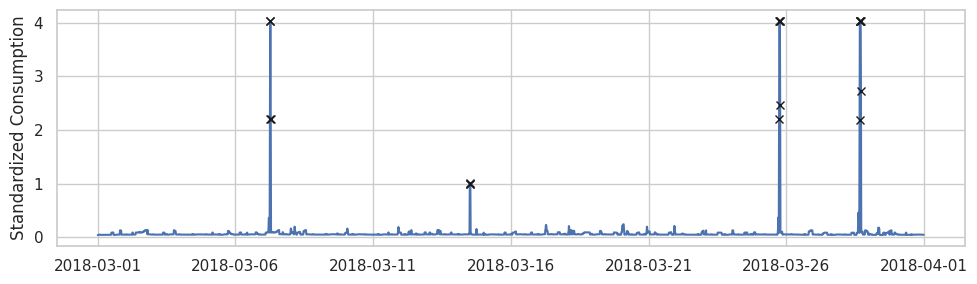

In [34]:
df = building_data[15]
df = df.loc[df.timestamp.dt.month == month]
anomalies = df.loc[np.abs(df.prediction - df.standardized_energy) > 2.0]

plt.figure(figsize=(10, 3))
plt.plot(df.timestamp, df[TARGET_COL])
plt.plot(anomalies.timestamp, anomalies[TARGET_COL], 'kx')
plt.xticks(pd.date_range('2018-03-01', '2018-04-01', periods=7))
plt.ylabel('Standardized Consumption')
plt.tight_layout()
plt.show()

The figure shows that we were successfully able to detect the large spikes in the energy consumption. A natural first thought is to use the average energy consumption of the spikes as another feature; however, our analysis shows that it is highly correlated with `predicability` and is thus not helpful in downstream clustering models. However, this information can still help us design a better DR program. In particular, the average energy consumption of the spikes can be used to appropriately size a battery for each building in the program. 


<a id="unsupervised-learning"></a>

# Unsupervised Learning  <a href="#toc"><i class="fa fa-home"></i></a>

In this section, we'll leverage unsupervised learning techniques to uncover hidden patterns and groupings within our building energy consumption data. By grouping buildings based on their energy consumption patterns, we can gain valuable insights into the different types of energy users and tailor our demand response strategies accordingly.

We will explore three main types of clusters:
* **Size-based clusters:** These clusters will differentiate between smaller (likely residential) and larger (likely commercial) buildings based on their annual energy consumption.
* **Temporal-based clusters:** These clusters will capture the temporal aspects of energy consumption, such as seasonality and weekday/weekend patterns, to identify buildings with similar usage patterns over time.
* **Uncertainty-based clusters:** These clusters will group buildings based on the predictability and variability of their energy consumption, helping us understand the uncertainty associated with different types of buildings.
By leveraging unsupervised learning techniques, we aim to uncover meaningful patterns and insights that can inform our demand response strategies and help us better understand the diverse energy consumption behaviors of different buildings.

The quality of clusters is often assessed using intra- and inter-cluster distances [[5]](#ref). However, distance-based metrics alone may not fully capture a cluster's suitability for downstream applications, particularly demand response programs. To address this, we evaluate cluster quality using a multi-faceted approach that includes both traditional metrics and those less commonly used in clustering contexts. We argue that the following factors are also crucial for assessing cluster suitability for DR programs:
* **Cluster size:** DR programs are impractical for clusters with too few participants.
* **Total energy consumption:** Assuming load flexibility, clusters with higher energy consumption offer greater potential for DR programs.
* **Peak energy consumption:** Peak demand is a major concern for power systems, making this a key factor in cluster evaluation.

Here's a summary of all the clusters that we will be examining. 

<a id="unsupervised-learning-toc"></a>

| **Cluster Name** | **Type** | **Description** |
| :--- | :--- | :--- |
| **<a href="#size-clusters">Size-Based Clusters</a>** | Size | Groups buildings into small (residential) and large (commercial). |
| **<a href="#seasonality-clusters">Seasonality Clusters</a>** | Temporal | Groups data based on thier seasonal profile. |
| **<a href="#weekday-weekend-cluster">Weekday vs Weekend Clusters</a>** | Temporal | Groups buildings by whether they have higher or lower average weekday consumption. |
| **<a href="#uncertainty-clusters">Uncertainty-Based Clusters</a>** | Uncertainty | Groups buildings into low and high uncertainty.|

In [14]:
def summarize_cluster(cluster_metadata, cluster_name):
    
    df = cluster_metadata.groupby(cluster_name).agg(
        building_count=(cluster_name, 'size'),
        residential_count = ('size_cluster', lambda x : sum(x == 'Residential')),
        commercial_count = ('size_cluster', lambda x : sum(x == 'Commercial')),
        sum_total_yearly_energy_consumption=('total_yearly_energy_consumption', 'sum'),
        mean_total_yearly_energy_consumption=('total_yearly_energy_consumption', 'mean'),
        mean_weekday_weekend_consumption_ratio=('weekday_weekend_consumption_ratio', 'mean'),
        mean_spectral_flatness=('spectral_flatness', 'mean'),
        mean_predictability=('predictability', 'mean'),
    )
    
    df['fraction_total_yearly_energy_consumption'] = df['sum_total_yearly_energy_consumption'] / df['sum_total_yearly_energy_consumption'].sum()

    # format
    df['building_count'] = [f'{x} ({100*x/1277:0.2f}%)' for x in df.building_count]
    df['residential_count'] = [f'{x} ({100*(x/1277):0.2f}%)' for x in df.residential_count]
    df['commercial_count'] = [f'{x} ({100*x/1277:0.2f}%)' for x in df.commercial_count]
    df['sum_total_yearly_energy_consumption'] = [f'{x/1e6:0.2f} GWh ({100*f:0.2f}%)' for x,f in zip(df.sum_total_yearly_energy_consumption, df.fraction_total_yearly_energy_consumption)]
    df['mean_total_yearly_energy_consumption'] = [f'{x/1e3:0.2f} MWh' for x in df.mean_total_yearly_energy_consumption]

    # reorder
    df = df[[
        'building_count',
        'residential_count',
        'commercial_count',
        'sum_total_yearly_energy_consumption',
        'mean_total_yearly_energy_consumption', 
        'mean_weekday_weekend_consumption_ratio', 
        'mean_spectral_flatness', 
        'mean_predictability', 
    ]]

    # rename
    df = df.rename(columns={
        'building_count': 'Building Count',
        'residential_count': 'Residential Building Count',
        'commercial_count': 'Commercial Building Count',
        'sum_total_yearly_energy_consumption': 'Group Consumption (yearly)',
        'mean_total_yearly_energy_consumption': 'Average Building Consumption (yearly)',
        'mean_weekday_weekend_consumption_ratio': 'Weekday/Weekend Consumption Ratio',
        'mean_spectral_flatness': 'Log Spectral Flatness',
        'mean_predictability': 'Predictability',       
    }).T

    cluster_display_name = cluster_name.replace('_', ' ').title()
    df.columns = pd.MultiIndex.from_tuples([(cluster_display_name, x) for x in df.columns])
            
    return df


cluster_metadata = pd.DataFrame(dict(
    bldg_id = range(1,1278), 
    total_yearly_energy_consumption=total_yearly_energy_consumption,
    weekday_weekend_consumption_ratio=weekday_weekend_consumption_ratio,
    spectral_flatness=np.log10(spectral_flatness),
    predictability=predictability,
))

<a id="size-clusters"></a>
## Size-Based Clusters  <a href="#unsupervised-learning"><i class="fa fa-arrow-up"></i></a>
During feature engineering, we found that a 35,000 kWh threshold effectively distinguished smaller (likely residential) buildings from larger (likely commercial) ones.  As discussed earlier, this distinction is important when designing demand response (DR) programs, as residential buildings may require aggregation to effectively participate due to their lower energy capacity. 

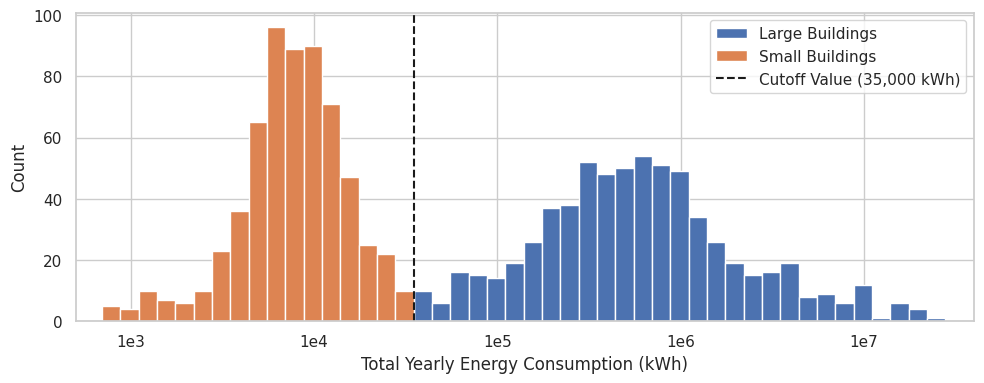

In [15]:
cluster_metadata['size_cluster'] = np.where(total_yearly_energy_consumption > 35000, 'Commercial', 'Residential')
large_indices = np.where(total_yearly_energy_consumption > 35000)[0]
small_indices = np.where(total_yearly_energy_consumption < 35000)[0]

plt.figure(figsize=(10, 4))

bins = np.linspace(-2, 3, 51) + np.log10(35000)
plt.hist(np.log10(total_yearly_energy_consumption[large_indices]), bins=bins, label='Large Buildings', color='C0')
plt.hist(np.log10(total_yearly_energy_consumption[small_indices]), bins=bins, label='Small Buildings', color='C1')
plt.axvline(np.log10(35000), linestyle='--', color='k', label='Cutoff Value (35,000 kWh)')
plt.xticks(range(3, 8), [f'1e{x}' for x in range(3, 8)])
plt.xlabel('Total Yearly Energy Consumption (kWh)')
plt.ylabel('Count')
plt.xlim(2.7, 7.6)
plt.legend()

plt.tight_layout()
plt.show()

Again, in the following analysis, we make the assumption that large buildings are commercial and small buildings are residential. The table below summarizes key statistics for each cluster.

In [16]:
cluster_metadata['size_cluster'] = np.where(total_yearly_energy_consumption > 35000, 'Commercial', 'Residential')
summarize_cluster(cluster_metadata, 'size_cluster')

Size Cluster                  
                                                Commercial       Residential
Building Count                                661 (51.76%)      616 (48.24%)
Residential Building Count                       0 (0.00%)      616 (48.24%)
Commercial Building Count                     661 (51.76%)         0 (0.00%)
Group Consumption (yearly)             968.97 GWh (99.41%)  5.72 GWh (0.59%)
Average Building Consumption (yearly)          1465.92 MWh          9.28 MWh
Weekday/Weekend Consumption Ratio                 1.357101          1.021364
Log Spectral Flatness                            -3.114477         -1.805511
Predictability                                    0.432953          0.253383

The table above shows that commercial buildings account for the vast majority of energy consumption (99%+), and residential buildings exhibit more unpredictable usage patterns, which aligns with our expectations.


<a id="temporal-clusters"></a>
## Temporal-Based Clusters  <a href="#unsupervised-learning"><i class="fa fa-arrow-up"></i></a>
In this section, we'll use the temporal features we derived to cluster our building data. We'll explore two types of temporal clusters:

* **Seasonality clusters:** These groups distinguish buildings based on whether they exhibit high energy consumption during specific seasons (summer vs. winter) and/or times of day (morning, noon, evening). This helps us understand how consumption patterns vary throughout the year.

* **Weekday vs Weekend clusters:** These groups identify buildings that consistently consume more or less energy on weekdays compared to weekends. This information is valuable for implementing demand response strategies like load shedding or load shifting.

By analyzing these clusters, we can gain valuable insights into how different buildings use energy and tailor our demand response strategies accordingly.


<a id="seasonality-clusters"></a>
### Seasonality  <a href="#unsupervised-learning-toc"><i class="fa fa-arrow-up"></i></a>

In this subsection, we'll cluster our data using the `seasonality` feature. We found that the standard K-means algorithm with 3 components produces adequete results and more complicated approaches did not yield significantly more insightful clusters. See cluster_analysis.ipynb for details. 

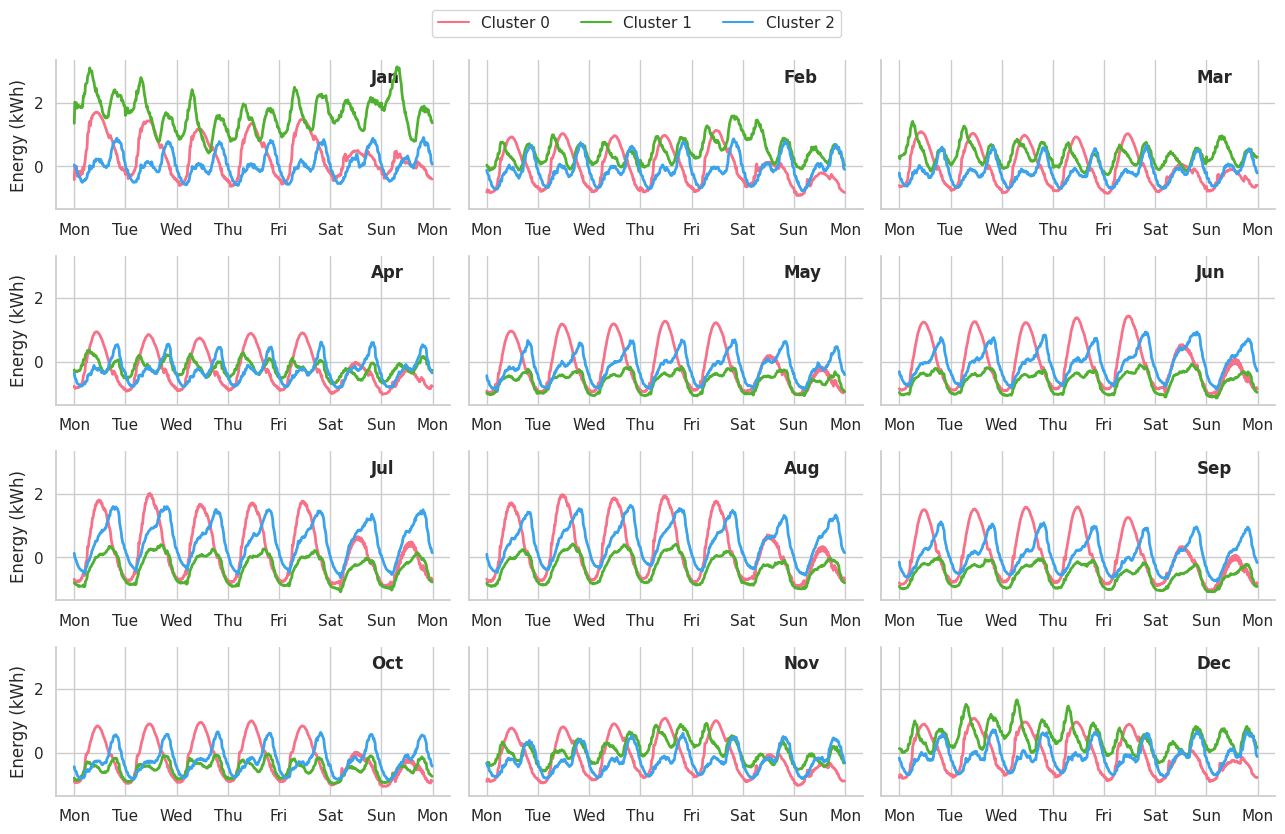

In [17]:
n_clusters = 3

with contextlib.redirect_stderr(open(os.devnull, 'w')):    
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=1)
    seasonality_cluster_labels = kmeans.fit_predict(temporal_features)
cluster_metadata['seasonality_cluster'] = seasonality_cluster_labels

df = pd.concat([
    pd.DataFrame(dict(
        cluster_num=cluster_num,
        month_name=np.repeat([x[:3] for x in MONTH_NAMES], 7*96),
        time_of_week=np.tile(range(7*96), 12),
        value=temporal_features[seasonality_cluster_labels == cluster_num].mean(0)
    ))
    for cluster_num in range(n_clusters)    
])

color_palette = sns.color_palette('husl', n_colors=n_clusters)

g = sns.relplot(
    data=df,
    x='time_of_week', y='value', col='month_name', hue='cluster_num', units='cluster_num',
    estimator=None, kind='line', linewidth=2, zorder=5, col_wrap=3, height=2, aspect=2.0, 
    palette=color_palette
    
)

for month, ax in g.axes_dict.items():
    ax.text(.8, .85, month, transform=ax.transAxes, fontweight='bold')
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
    ax.set_xticks(96*np.arange(8), [WEEKDAY_NAMES[i % 7][:3] for i in np.arange(8)])
    
g.fig.subplots_adjust(hspace=0.1, wspace=0.1)        
g._legend.set_visible(False)
g.fig.legend(handles=g._legend.legend_handles, ncol=n_clusters, loc='upper center',
             labels=[f'Cluster {i}' for i in range(n_clusters)], bbox_to_anchor=(0.5, 1.05))
g.set_axis_labels('', 'Energy (kWh)')    
g.set_titles('')
plt.tight_layout()
plt.show()    

The figure above shows clear differences in the average energy profiles of the clusters. We've qualitatively summarized the clusters in the following table and assigned names to the clusters based on their characteristics.

| **Cluster Name: number (color)** | **Month-to-Month Peaks** | **Day-to-Day Pattern** | **Weekday/Weekend** |
|-----|:-----|:-----|:-----|
| **Winter and Summer Noon: 0 (red)** | Winter (Jan); Summer (June, July, Aug, Sep) | Large noon peaks throughout the year. |  Different |
| **Winter Morning: 1 (green)** | Winter (Jan, Dec) | Large winter morning peaks. | Similar | 
| **Summer Evening: 2 (blue)** | Summer (Jul, Aug) | Large evening peaks throughout the year. Small winter morning peaks. | Similar | 


The following table shows buildings statistics for each cluster. 

In [18]:
cluster_metadata['seasonality_cluster'] = 'Winter and Summer Noon'
cluster_metadata.loc[seasonality_cluster_labels == 1, 'seasonality_cluster'] = 'Winter Morning'
cluster_metadata.loc[seasonality_cluster_labels == 2, 'seasonality_cluster'] = 'Summer Evening'
summarize_cluster(cluster_metadata, 'seasonality_cluster')

Seasonality Cluster                     \
                                           Summer Evening     Winter Morning   
Building Count                               339 (26.55%)       430 (33.67%)   
Residential Building Count                   284 (22.24%)       308 (24.12%)   
Commercial Building Count                      55 (4.31%)        122 (9.55%)   
Group Consumption (yearly)              49.60 GWh (5.09%)  96.41 GWh (9.89%)   
Average Building Consumption (yearly)          146.33 MWh         224.21 MWh   
Weekday/Weekend Consumption Ratio                1.014854            1.08817   
Log Spectral Flatness                           -1.998687          -2.135374   
Predictability                                   0.268443           0.309385   

                                                              
                                      Winter and Summer Noon  
Building Count                                  508 (39.78%)  
Residential Building Count                        24 (1.88%)  
Commercial Building Count                       484 (37.90%)  
Group Consumption (yearly)               828.68 GWh (85.02%)  
Average Building Consumption (yearly)            1631.25 MWh  
Weekday/Weekend Consumption Ratio                   1.406015  
Log Spectral Flatness                              -3.100586  
Predictability                                      0.429582

Note that each of the clusters has sufficient number of buildings (at least 25% of the buildings). 
The residential buildings are roughly evenly split into the "Summer Evening" and "Winter Morning" clusters while much of the commercial buildings are assigned to the "Winter and Summer Noon" cluster. As a consequence, the "Winter and Summer Noon" cluster makes up most of the total energy consumption (85.02%). 

<a id="weekday-weekend-clusters"></a>
### Weekday vs Weekend  <a href="#unsupervised-learning-toc"><i class="fa fa-arrow-up"></i></a>

In this subsection, we'll cluster our data based on the weekday_weekend_consumption_ratio feature. We'll divide the buildings into two groups: those with a ratio greater than 1 (higher weekday consumption) and those with a ratio less than or equal to 1 (higher or equal weekend consumption). This clustering will help us identify buildings that are good candidates for load shedding/building programs or ToU programs.

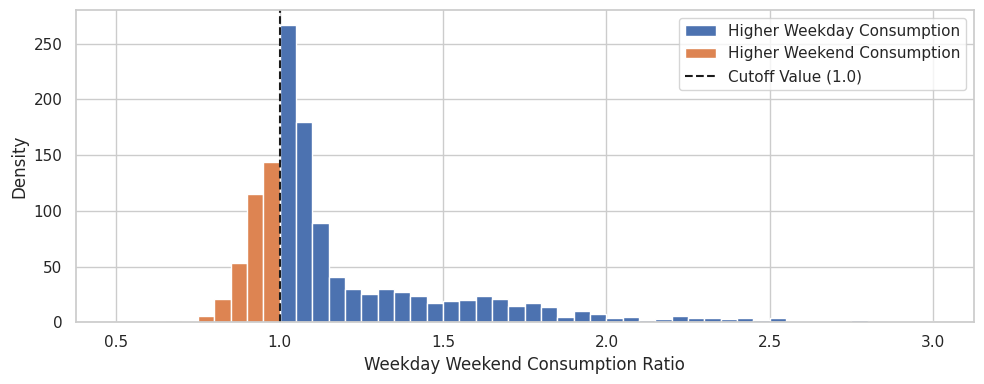

In [19]:
cluster_metadata['weekday_weekend_cluster'] = np.where(weekday_weekend_consumption_ratio > 1, 'Higher Weekday Consumption', 'Higher Weekend Consumption')
weekday_indices = np.where(weekday_weekend_consumption_ratio > 1)[0]
weekend_indices = np.where(weekday_weekend_consumption_ratio <= 1)[0]

plt.figure(figsize=(10, 4))

bins = np.linspace(0.5, 3.0, 51)
plt.hist(weekday_weekend_consumption_ratio[weekday_indices], bins=bins, label='Higher Weekday Consumption', color="C0")
plt.hist(weekday_weekend_consumption_ratio[weekend_indices], bins=bins, label='Higher Weekend Consumption', color="C1")
plt.axvline(1.0, linestyle='--', color='k', label='Cutoff Value (1.0)')
plt.xlabel('Weekday Weekend Consumption Ratio')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

The plot illustrates a clear difference in the weekday/weekend energy consumption patterns. For example, some buildings have `weekday_weekend_consumption_ratio > 2.5` which means that on average, the weekday consumption is 2.5 times higher than the weekend consumption. 

In [20]:
summarize_cluster(cluster_metadata, 'weekday_weekend_cluster')

Weekday Weekend Cluster  \
                                      Higher Weekday Consumption   
Building Count                                      936 (73.30%)   
Residential Building Count                          363 (28.43%)   
Commercial Building Count                           573 (44.87%)   
Group Consumption (yearly)                   889.18 GWh (91.23%)   
Average Building Consumption (yearly)                 949.98 MWh   
Weekday/Weekend Consumption Ratio                       1.291106   
Log Spectral Flatness                                  -2.642379   
Predictability                                          0.362198   

                                                                  
                                      Higher Weekend Consumption  
Building Count                                      341 (26.70%)  
Residential Building Count                          253 (19.81%)  
Commercial Building Count                             88 (6.89%)  
Group Consumption (yearly)                     85.51 GWh (8.77%)  
Average Building Consumption (yearly)                 250.76 MWh  
Weekday/Weekend Consumption Ratio                       0.931756  
Log Spectral Flatness                                  -2.045738  
Predictability                                          0.302781

As expected, most buildings (936 or 73.3%) have higher weekday consumption, accounting for 91.23% of the total annual load. However, a notable fraction (341 or 26.7%) show higher weekend consumption, contributing 8.77% of the total load. Despite these differences in consumption patterns, both clusters exhibit similar uncertainty metrics. Notably, the average weekday consumption for buildings in the "Higher Weekday Consumption" cluster is about 30% greater than their weekend consumption. In contrast, buildings in the "Higher Weekend Consumption" cluster have, on average, 7% greater consumption on weekends compared to weekdays.

<a id="uncertainty-clusters"></a>
## Uncertainty-Based Clusters  <a href="#unsupervised-learning-toc"><i class="fa fa-arrow-up"></i></a>

In this section, we'll combine our uncertainty features (`predictability` and `spectral_flatness`) to construct uncertainty-based clusters. We've decided to use a Gaussian Mixture Model instead of K-means since we found it visually produces better results. Furthermore, we decided to use two clusters because there are two visually distinct groups in the data. See cluster_analysis.ipynb for details. 

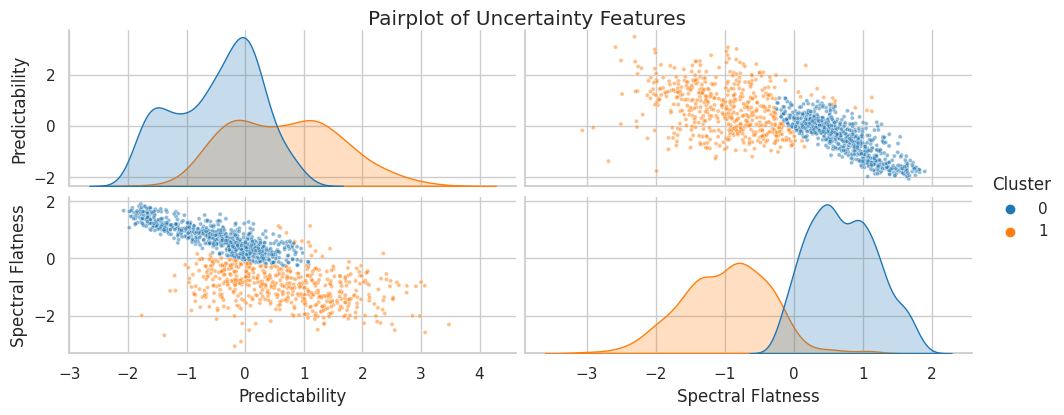

In [21]:
n_clusters = 2
uncertainty_features = np.vstack([predictability, np.log10(spectral_flatness)]).T
uncertainty_features -= uncertainty_features.mean(0, keepdims=True)
uncertainty_features /= uncertainty_features.std(0, keepdims=True)

with contextlib.redirect_stderr(open(os.devnull, 'w')):    
    gmm = GaussianMixture(n_components=n_clusters, random_state=1)
    uncertainty_cluster_labels = gmm.fit_predict(uncertainty_features)

data = pd.DataFrame(uncertainty_features, columns=['Predictability', 'Spectral Flatness'])
data['Cluster'] = uncertainty_cluster_labels

sns.pairplot(data, hue='Cluster', palette='tab10', diag_kind='kde', markers='.',
             plot_kws={'alpha': 0.5}, height=2, aspect=2.5) 
plt.suptitle('Pairplot of Uncertainty Features', y=1.02)
plt.show()


Visually, there are two distinct groups and the clustering algorithm does a relatively good job of identifying the groups. 

In [22]:
cluster_metadata['uncertainty_cluster'] = np.where(uncertainty_cluster_labels == 1, 'Low Uncertainty', 'High Uncertainty')
summarize_cluster(cluster_metadata, 'uncertainty_cluster')

Uncertainty Cluster  \
                                          High Uncertainty   
Building Count                                743 (58.18%)   
Residential Building Count                    565 (44.24%)   
Commercial Building Count                     178 (13.94%)   
Group Consumption (yearly)             162.01 GWh (16.62%)   
Average Building Consumption (yearly)           218.05 MWh   
Weekday/Weekend Consumption Ratio                 1.118174   
Log Spectral Flatness                            -1.840491   
Predictability                                    0.267943   

                                                            
                                           Low Uncertainty  
Building Count                                534 (41.82%)  
Residential Building Count                      51 (3.99%)  
Commercial Building Count                     483 (37.82%)  
Group Consumption (yearly)             812.68 GWh (83.38%)  
Average Building Consumption (yearly)          1521.87 MWh  
Weekday/Weekend Consumption Ratio                 1.302248  
Log Spectral Flatness                            -3.377114  
Predictability                                      0.4554

We find that both clusters have a sufficient number of buildings and as expected, the high uncertainy cluster is mainly residential while the low uncertainy cluster is mainly commercial. 

<a id="interpretation"></a>
# Interpretation <a href="#toc"><i class="fa fa-home"></i></a>
This section outlines several Demand Response (DR) programs aimed at improving grid stability, optimizing energy use, and saving costs for participants. Here's a summary of all the programs that we will be examining. 

<a id="interpretation-toc"></a>

| **Program Name** | **Description** |
| :--- | :--- |
| **<a href="#size-program">Small Building Aggregation</a>** | Aggregates small buildings' energy flexibility through partnerships with VPPs or aggregators. |
| **<a href="#seasonal-program">Seasonal Demand Response</a>** | Optimizes energy consumption based on seasonal patterns using targeted pricing and efficiency measures. |
| **<a href="#weekday-weekend-program">Weekday Peak Reduction</a>** | Reduces peak weekday demand using time-of-use pricing to incentivize load shifting. |
| **<a href="#uncertainty-program">Reducing Grid Uncertainty with Battery Storage</a>** | Deploys battery storage in high uncertainty buildings to smooth out demand fluctuations. |


<a id="size-program"></a>
## Small Building Aggregation <a href="#interpretation"><i class="fa fa-arrow-up"></i></a>
The Small Building Aggregation Program would aim to enable small buildings to actively participate in demand response initiatives by partnering with energy aggregators or Virtual Power Plants (VPPs) [[2]](#ref2). The program could facilitate partnerships between small buildings and aggregators/VPPs, which act as intermediaries to pool the collective energy flexibility of these buildings. During demand response events, the aggregator/VPP will coordinate the collective response of the buildings to reduce energy consumption or shift load to off-peak hours. Participating buildings could receive incentives, such as reduced energy rates, bill credits, or direct payments, and share any revenue generated from energy market participation. By leveraging these partnerships, the program aims to increase small building participation in demand response, enhance grid flexibility and stability, offer cost savings and potential revenue generation for participants, and accelerate the adoption of energy management technologies in small buildings.


<a id="seasonal-program"></a>
## Seasonal Demand Response <a href="#interpretation"><i class="fa fa-arrow-up"></i></a>
The Seasonal Demand Response Program would aim to optimize energy consumption and reduce peak demand during specific seasons and times of day based on the identified seasonality patterns (Summer Evening, Winter Morning, and Winter & Summer Noon) in our <a id="seasonality-clusters">seasonality clusters</a>. The program would implement a targeted seasonal pricing structure, offering lower rates during off-peak seasons and times of day and higher rates during peak seasons and times. Additionally, each building group could receive personalized recommendations for energy efficiency measures specific to their seasonal consumption patterns, such as promoting energy-efficient cooling systems for the Summer Evening group, encouraging the adoption of energy-efficient heating systems for the Winter Morning group, and focusing on measures that reduce energy consumption during both winter and summer noon for the Winter and Summer Noon group. Participating buildings could be offered incentives and rewards for successfully reducing their energy consumption during the targeted seasons and times of day, including reduced energy rates, rebates for implementing energy efficiency measures, and performance-based rewards.


<a id="weekday-weekend-program"></a>
## Weekday Peak Reduction  <a href="#interpretation"><i class="fa fa-arrow-up"></i></a>
The Weekday Peak Reduction Program would aim to reduce peak weekday energy consumption by introducing time-of-use (TOU) pricing to incentivize buildings with <a id="weekday-weekend-clusters">higher weekday consumption</a>, primarily commercial, to shift a portion of their weekday load to off-peak hours or weekends. The program would offer lower energy rates during off-peak hours and weekends and higher rates during weekday peak hours, encouraging load shifting through clear price signals. Participating buildings could be be provided with tailored load shifting strategies, such as scheduling energy-intensive processes during off-peak hours, implementing energy storage systems, and encouraging occupants to shift discretionary energy usage. By leveraging TOU pricing, the program anticipates reduced weekday peak demand, cost savings for participants, and increased adoption of energy storage and automation.


<a id="uncertainty-program"></a>
## Reducing Grid Uncertainty with Battery Storage <a href="#interpretation"><i class="fa fa-arrow-up"></i></a>
The Reducing Grid Uncertainty with Battery Storage program would aim to reduce grid uncertainty by targeting buildings with <a href="uncertainty-clusters">highly variable and unpredictable energy consumption patterns</a>, primarily residential, identified through uncertainty clusters. Participating buildings could be equipped with appropriately sized battery storage systems, with the storage capacity determined based on the amount of unpredictable load a building has (see the subsection on <a href="anomaly-detection">anomaly detection</a>). The program could offer financial incentives, such as reduced energy rates, rebates for battery storage installation, and performance-based rewards, to encourage participation. By deploying battery storage in high uncertainty buildings, the program anticipates reduced grid uncertainty, enhanced grid stability, increased renewable energy integration, and cost savings for participants.


<a id="conclusion"></a>
# Conclusion <a href="#toc"><i class="fa fa-home"></i></a>

In this work, we present a novel approach to clustering building energy consumption data using a combination of size, temporal, and uncertainty features. Our analysis reveals distinct patterns in energy usage across different building types and sizes, highlighting the importance of considering these factors when designing demand response (DR) programs. We propose four tailored DR programs that address the unique characteristics of each identified cluster.

Future work could focus on several areas to further refine and expand upon our findings. First, incorporating additional features, such as weather data or building occupancy information, could enhance the quality of the features and downstream clustering models. Second, pre-binning on size, which involves clustering by overall consumption (residential vs commercial) and then by load shape, has been shown to be an effective method for improving cluster quality [[6]](#ref6), [[7]](#ref7). However, for simplicity and to keep under the 10 cluster limit, we did not explore that idea further here. 



<a id="references"></a>
# References <a href="#toc"><i class="fa fa-home"></i></a>


<a id="ref1"></a>
[1] Matthew Motoki, Daniel Tabas, & Baosen Zhang. (2024). Modeling Temperature Dependence of Loads - An Additive Decomposition Approach.

<a id="ref1"></a>
[2] Jiayi Li, Matthew Motoki, & Baosen Zhang. (2024). Socially Optimal Energy Usage via Adaptive Pricing.

<a id="ref2"></a>
[3] Jiayi Li, Matthew Motoki, & Baosen Zhang. (2024). Balancing Fairness and Efficiency in Energy Resource Allocations.

<a id="ref4"></a>
[4] 
Toussaint, W. 2019. Evaluation of clustering techniques for generating household energy consumption patterns in a developing country.

<a id="ref5"></a>
[5] Amin Rajabi, Mohsen Eskandari, Mojtaba Jabbari Ghadi, Li Li, Jiangfeng Zhang, & Pierluigi Siano (2020). A comparative study of clustering techniques for electrical load pattern segmentation. *Renewable and Sustainable Energy Reviews, 120, 109628.*

<a id="ref6"></a>
[6] Hong An Cao, Christian Beckel, and Thorsten Staake. “Are domestic load profiles stable over time? An attempt to identify target households for demand side management campaigns”. In: *IECON Proc. (Industrial Electron. Conf.* (2013), pp. 4733–4738. ISSN : 1553-572X. DOI : 10.1109/IECON.2013.6699900.

<a id="ref7"></a>
[7] Sharon Xu, Edward Barbour, and Marta C González. “Household Segmentation by Load Shape and Daily Consumption”. In: *Proc. of. ACM SigKDD 2017 Conf. (2017),* pp. 1–9. DOI : 10.475/123. URL : http://humnetlab.mit.edu/wordpress/wp-content/uploads/2016/03/household-segmentation-load-shape-consumption.pdf.